Loading and preprocessing data...
Dataset shape before preprocessing: (1476, 8)
Performing feature engineering...
Dataset shape after feature engineering: (1471, 18)

Data Description:
          Rainfall        nino3      nino3.4        nino4  Arabian_Sea  \
count  1471.000000  1471.000000  1471.000000  1471.000000  1471.000000   
mean      0.835162    25.889869    27.012300    28.024671    27.482247   
std       1.540809     1.167257     0.866333     0.742012     1.095154   
min       0.010000    23.096881    24.483375    25.618471    25.307378   
25%       0.013191    24.971080    26.400549    27.525516    26.649491   
50%       0.111028    25.867187    27.033926    28.046833    27.375555   
75%       0.879077    26.772739    27.620276    28.569722    28.320996   
max      11.672129    29.205798    29.197979    30.244499    30.489403   

       equatorialindianocean  bayofbengal        SPI_1     month_sin  \
count            1471.000000  1471.000000  1471.000000  1.471000e+03   
mean

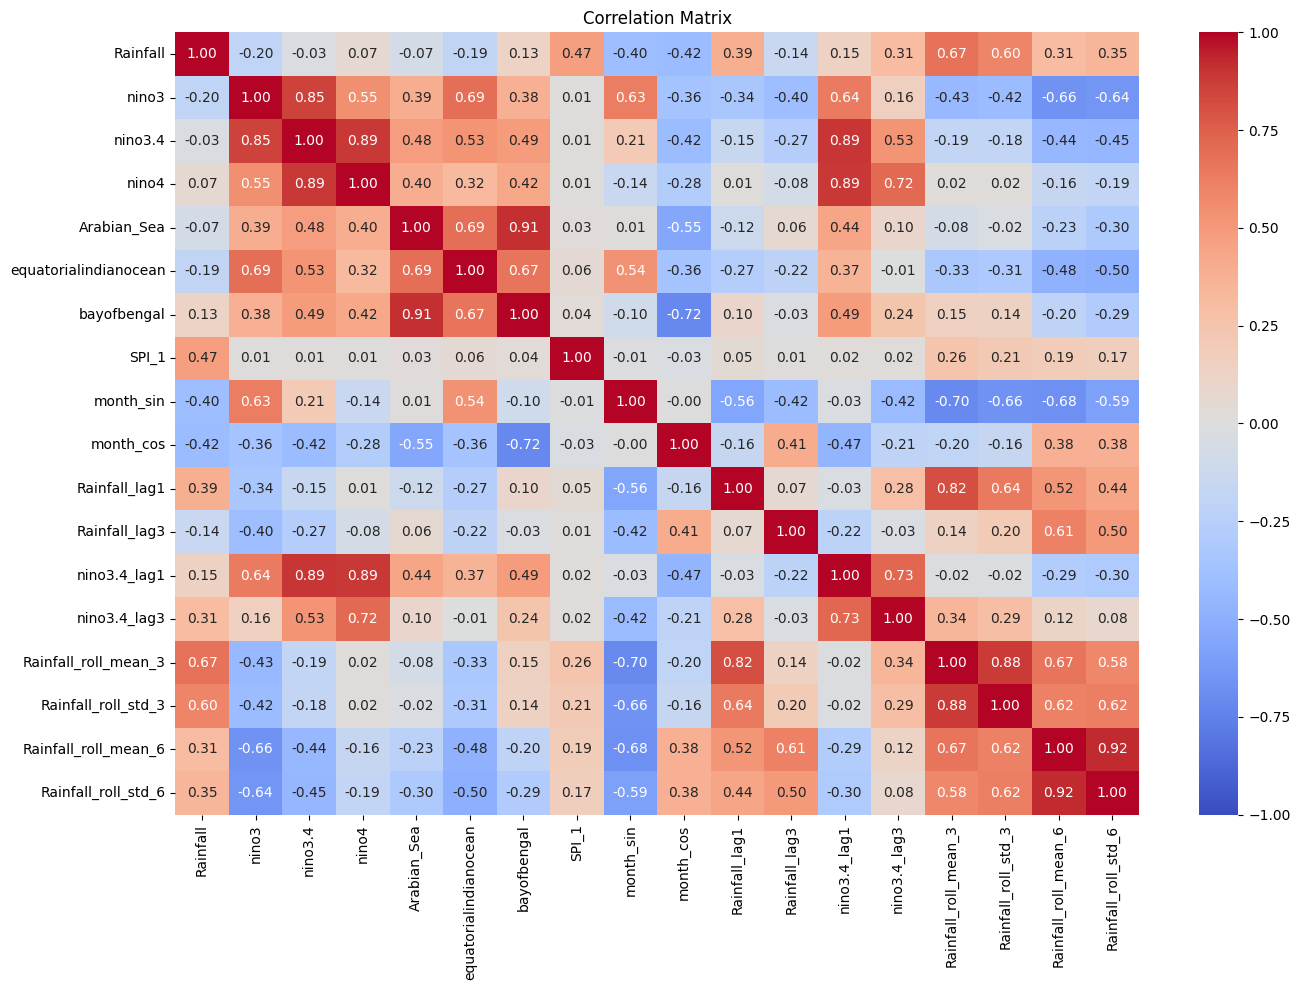

In [ ]:
# =========================
# Improved LSTM Pipeline on Rainfall-SST Dataset with SPI Calculation
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit

# -------------------------
# 1. Load and Preprocess Data
# -------------------------
print("Loading and preprocessing data...")
df = pd.read_csv("dataset_final_wre.csv")
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('Date', inplace=True)
df.drop(['year', 'month'], axis=1, inplace=True)
df.rename(columns={'Average Rainfall': 'Rainfall'}, inplace=True)
print(f"Dataset shape before preprocessing: {df.shape}")

# -------------------------
# 2. Feature Engineering
# -------------------------
print("Performing feature engineering...")
# Add seasonal features (cyclical encoding of months)
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Add lagged features for key indicators
for feature in ['Rainfall', 'nino3.4']:
    if feature in df.columns:
        for lag in [1, 3]:
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

# Add rolling statistics for rainfall
for window in [3, 6]:
    df[f'Rainfall_roll_mean_{window}'] = df['Rainfall'].rolling(window=window).mean()
    df[f'Rainfall_roll_std_{window}'] = df['Rainfall'].rolling(window=window).std()

# Drop NaNs created by lag/rolling operations
df.dropna(inplace=True)
print(f"Dataset shape after feature engineering: {df.shape}")

# -------------------------
# 3. Data Understanding
# -------------------------
print("\nData Description:")
print(df.describe())

# Create a correlation matrix and plot (optional - uncomment if needed)
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------
# 4. Preprocessing for LSTM
# -------------------------
print("\nPreparing data for LSTM...")
# Identify original features plus engineered features
base_features = ['nino3', 'nino3.4', 'nino4', 'Arabian_Sea', 'equatorialindianocean', 'bayofbengal']
lag_features = [col for col in df.columns if '_lag' in col]
roll_features = [col for col in df.columns if '_roll_' in col]
seasonal_features = ['month_sin', 'month_cos']
target_feature = ['Rainfall']

# Combine all features
all_features = base_features + lag_features + roll_features + seasonal_features + target_feature

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[all_features])
print(f"Scaled data shape: {scaled_data.shape}")

# Create sequences for LSTM
def create_sequences(data, target_idx, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :-1])  # All columns except the last (target)
        y.append(data[i+window, target_idx])  # Target column at future time step
    return np.array(X), np.array(y)

# Try multiple window sizes
window_sizes = [6, 12, 18, 24]
window_results = {}

# Store indices for the best window
best_window_X_train = None
best_window_X_test = None
best_window_y_train = None
best_window_y_test = None
best_window = 0
best_rmse = float('inf')

print("\nTesting different window sizes...")
for window_size in window_sizes:
    print(f"Testing window size: {window_size}")
    target_idx = len(all_features) - 1  # Target is the last column (Rainfall)
    X, y = create_sequences(scaled_data, target_idx=target_idx, window=window_size)

    # Split into train and test (80/20)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Quick model to test window size
    test_model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    test_model.compile(optimizer='adam', loss='mse')
    test_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    # Evaluate
    y_pred = test_model.predict(X_test)

    # Convert scaled predictions back to original scale for rainfall
    temp_pred = np.zeros((len(y_pred), len(all_features)))
    temp_pred[:, -1] = y_pred.flatten()

    temp_actual = np.zeros((len(y_test), len(all_features)))
    temp_actual[:, -1] = y_test

    y_pred_rainfall = scaler.inverse_transform(temp_pred)[:, -1]
    y_test_rainfall = scaler.inverse_transform(temp_actual)[:, -1]

    # Calculate metrics
    test_rmse = np.sqrt(mean_squared_error(y_test_rainfall, y_pred_rainfall))
    window_results[window_size] = test_rmse

    print(f"Window size {window_size}: RMSE = {test_rmse}")

    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_window = window_size
        best_window_X_train = X_train
        best_window_X_test = X_test
        best_window_y_train = y_train
        best_window_y_test = y_test

print(f"\nBest window size: {best_window} with RMSE = {best_rmse}")

# Use the best window size
X_train = best_window_X_train
X_test = best_window_X_test
y_train = best_window_y_train
y_test = best_window_y_test


Preparing data for LSTM...
Scaled data shape: (1471, 17)

Testing different window sizes...
Testing window size: 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Window size 6: RMSE = 1.1630070104730375
Testing window size: 12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Window size 12: RMSE = 1.1009722233670307
Testing window size: 18


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Window size 18: RMSE = 1.2067552028993151
Testing window size: 24


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Window size 24: RMSE = 1.0806866876733268

Best window size: 24 with RMSE = 1.0806866876733268


In [ ]:
# -------------------------
# 5. Build and Train Improved LSTM Model
# -------------------------
print("\nTraining improved LSTM model...")
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Define an improved model architecture
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile with Adam optimizer and tuned learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training improved LSTM model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0269 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0152 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0130 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0140 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0118 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0109 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0105 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0100 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0092 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 10/100
37/37 ━━━

In [ ]:
# # -------------------------
# # 6. Ensemble Model (Optional)
# # -------------------------
print("\nBuilding ensemble models...")
models = []

# Add the primary LSTM model
models.append(model)

# BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')
bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1,
                callbacks=[early_stopping, reduce_lr])
models.append(bilstm_model)

# GRU model
gru_model = Sequential([
    GRU(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1,
             callbacks=[early_stopping, reduce_lr])
models.append(gru_model)


Building ensemble models...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0389 - learning_rate: 0.0010
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0160 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0134 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0132 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0125 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0116 - learning_rate: 0.0010
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - learning_rate: 0.0010
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0106 - learning_rate: 0.0010
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0107 - learning_rate: 0.0010
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 13/50
37/37 

In [ ]:
# -------------------------
# 7. Predict and Evaluate
# -------------------------
print("\nGenerating and evaluating predictions...")
# Generate predictions for all models
model_predictions = []
for i, model in enumerate(models):
    print(f"Generating predictions for model {i+1}...")
    pred = model.predict(X_test)
    model_predictions.append(pred)

# Create ensemble prediction (average of all models)
y_pred_scaled = np.mean(model_predictions, axis=0)

# Prepare to inverse the scaling
test_pred_container = np.zeros((len(y_pred_scaled), len(all_features)))
test_pred_container[:, -1] = y_pred_scaled.flatten()
y_pred_rainfall = scaler.inverse_transform(test_pred_container)[:, -1]

test_actual_container = np.zeros((len(y_test), len(all_features)))
test_actual_container[:, -1] = y_test
y_test_rainfall = scaler.inverse_transform(test_actual_container)[:, -1]

# Calculate metrics for rainfall prediction
print("\nRainfall Prediction Metrics:")
r2 = r2_score(y_test_rainfall, y_pred_rainfall)
mae = mean_absolute_error(y_test_rainfall, y_pred_rainfall)
rmse = np.sqrt(mean_squared_error(y_test_rainfall, y_pred_rainfall))
print(f"R² Score: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")



Generating and evaluating predictions...
Generating predictions for model 1...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Generating predictions for model 2...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Generating predictions for model 3...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Rainfall Prediction Metrics:
R² Score: 0.6007792843720101
MAE: 0.5818271036105235
RMSE: 0.982952579688294


In [ ]:
# -------------------------
# 8. SPI Calculation
# -------------------------
print("\nCalculating SPI values...")
spi_scale = 3  # SPI-3 for smoother drought representation

def compute_spi(rainfall_series, scale=3):
    # Convert to pandas Series if it's not already
    if not isinstance(rainfall_series, pd.Series):
        rainfall_series = pd.Series(rainfall_series)

    # Calculate rolling sum for the given scale
    rolling = rainfall_series.rolling(window=scale).sum()

    # Calculate mean and std for normalization
    mean = rolling.mean()
    std = rolling.std()

    # Avoid division by zero
    std = np.where(std == 0, 1e-10, std)

    # Calculate SPI
    spi = (rolling - mean) / std
    return spi

# Calculate SPI for predictions and actual values
spi_pred = compute_spi(pd.Series(y_pred_rainfall), scale=spi_scale).dropna().reset_index(drop=True)
spi_actual = compute_spi(pd.Series(y_test_rainfall), scale=spi_scale).dropna().reset_index(drop=True)

# Make sure lengths match
min_len = min(len(spi_pred), len(spi_actual))
spi_pred, spi_actual = spi_pred[:min_len], spi_actual[:min_len]

# Evaluate SPI predictions
print("\nSPI Prediction Metrics:")
spi_r2 = r2_score(spi_actual, spi_pred)
spi_mae = mean_absolute_error(spi_actual, spi_pred)
spi_rmse = np.sqrt(mean_squared_error(spi_actual, spi_pred))
print(f"R² Score: {spi_r2}")
print(f"MAE: {spi_mae}")
print(f"RMSE: {spi_rmse}")


Calculating SPI values...

SPI Prediction Metrics:
R² Score: 0.7372760683049893
MAE: 0.33616467311982895
RMSE: 0.5116753812927389



Performing drought classification...
Drought Classification Accuracy: 0.8056


<Figure size 1200x1000 with 0 Axes>

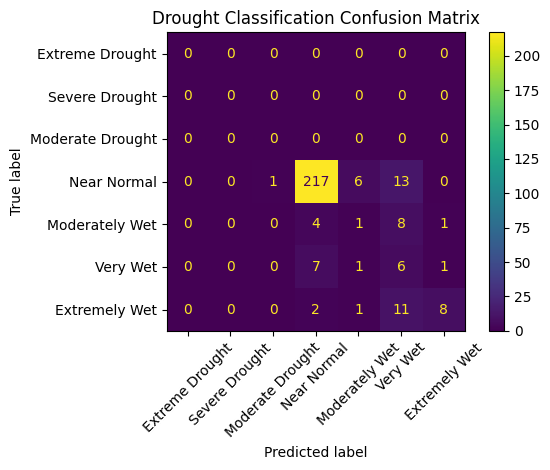


Creating visualizations...


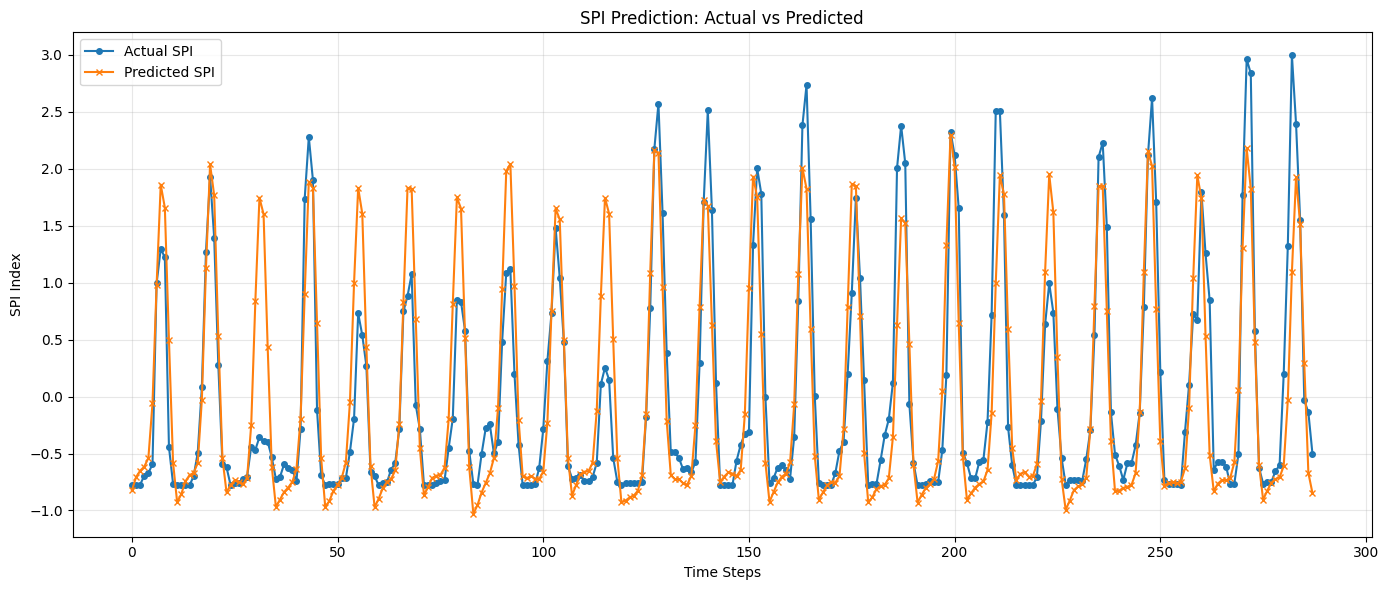

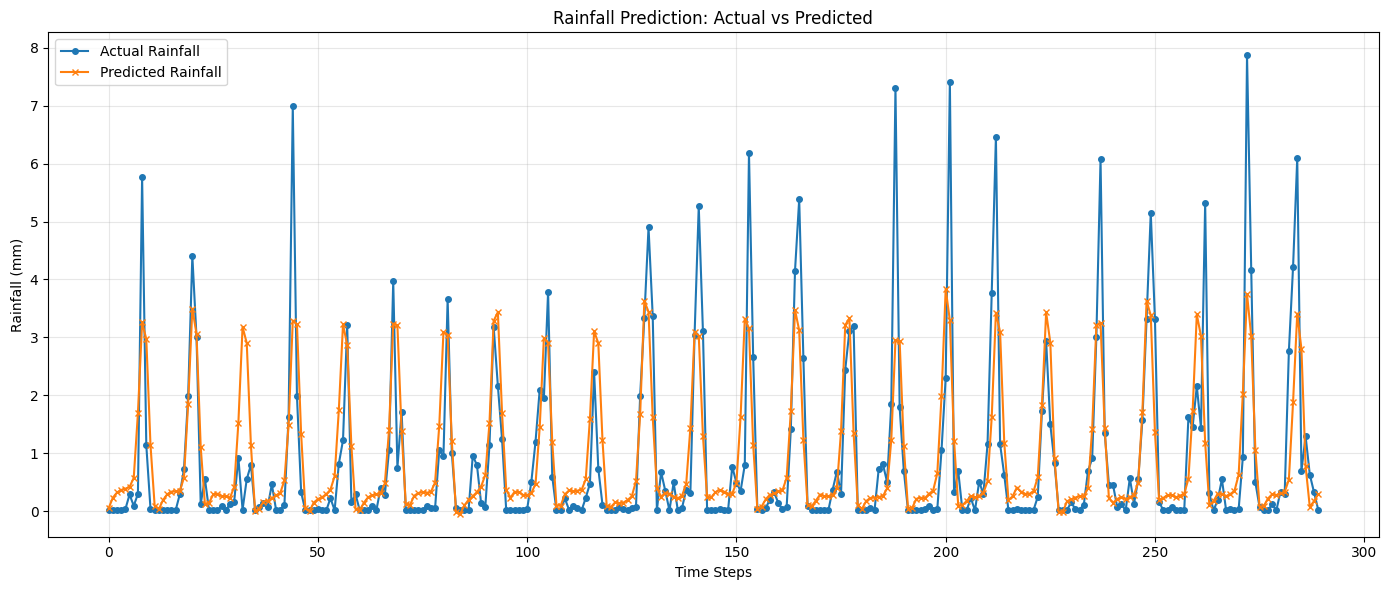

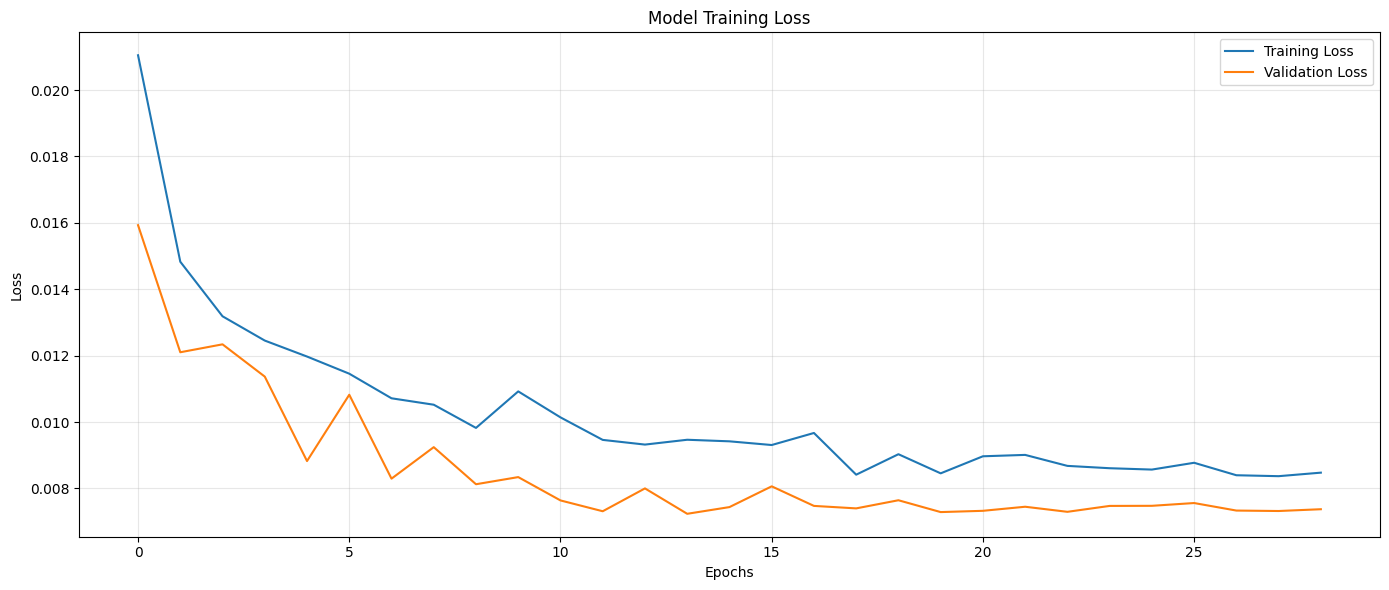


Analysis complete! Results and visualizations have been saved.


In [ ]:
# -------------------------
# 9. Drought Classification
# -------------------------
print("\nPerforming drought classification...")
def classify_drought(spi):
    if spi >= 2.0:
        return 'Extremely Wet'
    elif 1.5 <= spi < 2.0:
        return 'Very Wet'
    elif 1.0 <= spi < 1.5:
        return 'Moderately Wet'
    elif -1.0 < spi < 1.0:
        return 'Near Normal'
    elif -1.5 < spi <= -1.0:
        return 'Moderate Drought'
    elif -2.0 < spi <= -1.5:
        return 'Severe Drought'
    else:
        return 'Extreme Drought'

actual_classes = [classify_drought(s) for s in spi_actual]
predicted_classes = [classify_drought(s) for s in spi_pred]

# Calculate classification accuracy
accuracy = np.sum(np.array(actual_classes) == np.array(predicted_classes)) / len(actual_classes)
print(f"Drought Classification Accuracy: {accuracy:.4f}")

# Confusion Matrix
labels = ['Extreme Drought', 'Severe Drought', 'Moderate Drought', 'Near Normal', 'Moderately Wet', 'Very Wet', 'Extremely Wet']
cm = confusion_matrix(actual_classes, predicted_classes, labels=labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)

plt.figure(figsize=(12, 10))
cmd.plot(xticks_rotation=45)
plt.title("Drought Classification Confusion Matrix")
plt.tight_layout()
plt.show()

# -------------------------
# 10. Visualization
# -------------------------
print("\nCreating visualizations...")
# Plot SPI values
plt.figure(figsize=(14, 6))
plt.plot(spi_actual, label='Actual SPI', marker='o', markersize=4)
plt.plot(spi_pred, label='Predicted SPI', marker='x', markersize=4)
plt.title('SPI Prediction: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('SPI Index')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot rainfall values
plt.figure(figsize=(14, 6))
plt.plot(y_test_rainfall, label='Actual Rainfall', marker='o', markersize=4)
plt.plot(y_pred_rainfall, label='Predicted Rainfall', marker='x', markersize=4)
plt.title('Rainfall Prediction: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Rainfall (mm)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nAnalysis complete! Results and visualizations have been saved.")